In [3]:


import numpy as np
import pandas as pd



In [4]:
df=pd.read_csv('data.csv')

In [5]:
print(df.head(10))
print("Null values in the data are ",df.isnull().sum())

                                          clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1
3  i ve kind of stuffed around a lot in my life d...              1
4  sleep is my greatest and most comforting escap...              1
5  i m year old turning soon in a few month i liv...              1
6  i live alone and despite me being prone to lon...              1
7  i m not looking for sympathy just simply to st...              1
8  i don t know how to communicate all of my thou...              1
9  mom i m sad it hurt in my heart the feeling fa...              1
Null values in the data are  clean_text       0
is_depression    0
dtype: int64


In [6]:
print(df.shape)
print("no.of duplicates",df.duplicated().sum())

(7731, 2)
no.of duplicates 81


In [7]:
df.drop_duplicates(inplace=True)


In [8]:
print(df.shape)

(7650, 2)


In [9]:
df.rename(columns={'clean_text':'text','is_depression':'test'},inplace=True)

In [10]:
print(df.dtypes)

text    object
test     int64
dtype: object


In [11]:
!pip install nltk
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
tokens = df['text'].apply(word_tokenize)
tokens_lower = tokens.apply(lambda x: [word.lower() for word in x])

nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tokens_filtered = tokens_lower.apply(lambda x: [word for word in x if word not in stop_words])

!pip install rake-nltk

from rake_nltk import Rake
r = Rake()

# Apply RAKE algorithm to extract keywords
df['keywords'] = df['text'].apply(lambda x: r.extract_keywords_from_text(x))
df['keywords'] = df['text'].apply(lambda x: r.get_ranked_phrases())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
from transformers import BertTokenizer

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the cleaned sentences containing only keywords
tokenized_sentences = []

for sentence in df['keywords']:
    # Convert list of keywords into a single string
    sentence_str = ' '.join(sentence)
    # Tokenize the sentence
    tokens = tokenizer.tokenize(sentence_str)
    # Add [CLS] and [SEP] tokens for BERT
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    # Convert tokens to token IDs
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    # Add tokenized sentence to the list
    tokenized_sentences.append(token_ids)

# Show tokenized sentences
print(tokenized_sentences)


[[101, 7771, 6919, 2135, 2633, 2699, 25414, 8450, 2047, 2622, 4438, 2240, 4003, 2072, 2066, 3609, 2442, 3524, 2358, 11823, 102], [101, 7771, 6919, 2135, 2633, 2699, 25414, 8450, 2047, 2622, 4438, 2240, 4003, 2072, 2066, 3609, 2442, 3524, 2358, 11823, 102], [101, 7771, 6919, 2135, 2633, 2699, 25414, 8450, 2047, 2622, 4438, 2240, 4003, 2072, 2066, 3609, 2442, 3524, 2358, 11823, 102], [101, 7771, 6919, 2135, 2633, 2699, 25414, 8450, 2047, 2622, 4438, 2240, 4003, 2072, 2066, 3609, 2442, 3524, 2358, 11823, 102], [101, 7771, 6919, 2135, 2633, 2699, 25414, 8450, 2047, 2622, 4438, 2240, 4003, 2072, 2066, 3609, 2442, 3524, 2358, 11823, 102], [101, 7771, 6919, 2135, 2633, 2699, 25414, 8450, 2047, 2622, 4438, 2240, 4003, 2072, 2066, 3609, 2442, 3524, 2358, 11823, 102], [101, 7771, 6919, 2135, 2633, 2699, 25414, 8450, 2047, 2622, 4438, 2240, 4003, 2072, 2066, 3609, 2442, 3524, 2358, 11823, 102], [101, 7771, 6919, 2135, 2633, 2699, 25414, 8450, 2047, 2622, 4438, 2240, 4003, 2072, 2066, 3609, 2442, 

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       771
           1       0.00      0.00      0.00       759

    accuracy                           0.50      1530
   macro avg       0.25      0.50      0.34      1530
weighted avg       0.25      0.50      0.34      1530



C:\Users\karth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


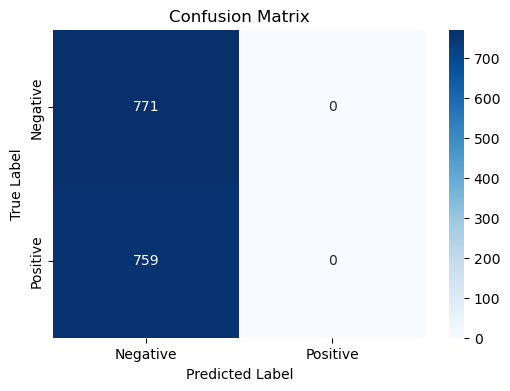

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert tokenized sentences into numerical features
X = tokenized_sentences
y = df['test']  # Assuming 'label' is the column containing the target labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier with regularization (C=0.1)
svm_classifier = SVC(kernel='linear', C=0.01)  # You can choose different kernels based on your data
svm_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = svm_classifier.predict(X_test)

# Evaluate the performance of the SVM classifier
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Accuracy: 0.5037037037037037
Precision: 0.25371742112482853
Recall: 0.5037037037037037
F1 Score: 0.3374566684911512


C:\Users\karth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


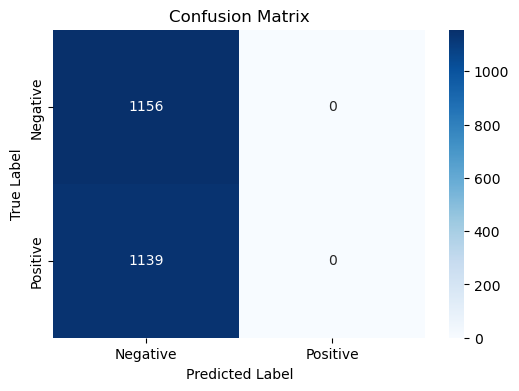

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Split the dataset into training and testing sets with 70% training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Logistic Regression classifier with regularization (C=0.1)
logistic_regression_classifier = LogisticRegression(max_iter=1000, C=0.1)  # Increase max_iter if needed
logistic_regression_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = logistic_regression_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [15]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Perform grid search to tune hyperparameters
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Initialize XGBoost classifier with best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_params)

# Train the model with the best parameters
best_xgb_classifier.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

# Predict on the test set
y_pred = best_xgb_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:")
print(conf_matrix)



Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5}
Accuracy: 0.5037037037037037
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[[1156    0]
 [1139    0]]


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty (L1 or L2)
    'solver': ['liblinear', 'saga']  # Solver algorithm
}

# Initialize logistic regression classifier
logistic_regression = LogisticRegression()

# Perform grid search to tune hyperparameters
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Initialize logistic regression classifier with best parameters
best_logistic_regression = LogisticRegression(**best_params)

# Train the model with the best parameters
best_logistic_regression.fit(X_train, y_train)

# Predict on the test set
y_pred = best_logistic_regression.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:")
print(conf_matrix)


C:\Users\karth\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Best Parameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.5037037037037037
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[[1156    0]
 [1139    0]]


C:\Users\karth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.503921568627451
Precision: 0.2539369473279508
Recall: 0.503921568627451
F1 Score: 0.3376997213487742


C:\Users\karth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


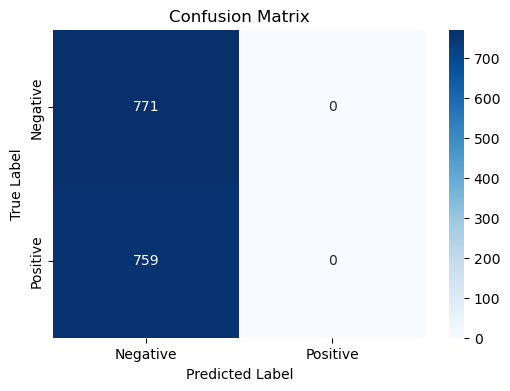

In [17]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Split the dataset into training and testing sets with 70% training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Train the XGBoost classifier
xgb_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = xgb_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
